In [2]:
using QuantumBayesian
using DifferentialEquations
using PyPlot
using Pkg

# Julia Stochastic Differential Equation Test

**Justin Dressel**, Dec 6, 2016 <br />
*Institute for Quantum Studies, Chapman University*

Using a simple qubit Rabi oscillation problem, test whether the built-in SDE solvers in the [DifferentialEquations](https://juliadiffeq.github.io/DiffEqDocs.jl/latest/tutorials/sde_example.html) package for Julia produce sensible results for even the simplest quantum problem of monitoring a single observable of a single qubit.

## Problem Specification

Consider a qubit orbiting in the x-z plane of the Bloch sphere with unit period, with continuous monitoring of the z observable.

### Qubit Hilbert Space

In [22]:
q = qubit()

QFactor: Qubit
Dims  : 2
Ops   : 'x', 'd', 'i', 'u', 'y', 'z'


### Global Constants

In [4]:
Ω  = 2*π;        # Rabi frequency
τ = 3.0;         # Measurement collapse timescale
Γ = 1/(2*τ);     # Measurement dephasing rate (quantum-limited efficiency)
T = (0.0, 3*τ);  # Time duration of simulation;

### Common Trajectory and Plotting Code

In [13]:
# Hamiltonian
H = (Ω/2)*q('y');

# Measurement dephasing
DM = sqrt(Γ/2)*q('z');

# Superoperators
dm = diss(DM)
mm = inn(sqrt(1/2)*DM)

# Deterministic part of evolution (Lindblad equation)
dρdt(ρ, p, t) = -im*comm(H, ρ) + dm(ρ)
dρdt2 = (du, ρ, p, t) -> du .= -im*comm(H, ρ) + dm(ρ) # SRIW1 no longer supports the inplace syntax above

# Ito stochastic part of evolution
dρdW(ρ, p, t) = mm(ρ)
dρdW2 = (du, ρ, p, t) -> du .= mm(ρ) # SRIW1 no longer supports the inplace syntax above

# Initial ground state
ρ0 = Array(ground(q));

In [6]:
# Plotting
function plot_solution(sol; plot_title="Monitored Rabi Oscillation")
    ts = range(T..., length=length(sol))
    @info("Timesteps: ",length(sol))
    # Get Bloch components
    xs = zeros(Float64, size(ts)) 
    ys = zeros(Float64, size(ts))
    zs = zeros(Float64, size(ts))
    for i in 1:length(sol)
        xs[i] = real(expect(sol[i], q('x')))
        ys[i] = real(expect(sol[i], q('y')))
        zs[i] = real(expect(sol[i], q('z')))
    end
    # Plot Bloch components vs. time
    p = plot(ts, xs, label=L"$x$")
    plot(ts, ys, label=L"$y$")
    ax = gca()
    ax.set_ylim([-1.1,1.1]) 
    plot(ts, zs, label=L"$z$")
    xlabel(L"$t/\tau$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    show()
end;

## Simulation and Plots

Define the problem, with moderate duration to show expected behavior.

In [14]:
probsde = SDEProblem(dρdt, dρdW, ρ0, T);
probsde2 = SDEProblem(dρdt2, dρdW2, ρ0, (0,6*2pi)); # SRIW1 no longer supports the inplace syntax above
probode = ODEProblem(dρdt, ρ0, T);

### Lindblad Euler evolution

Plot a reference unmonitored oscillation to verify Lindblad evolution is as expected. Use the explicitly first-order Euler method as a benchmark. The solution converges to acceptable precision by $dt=10^{-4}$.

  6.041442 seconds (17.18 M allocations: 1.043 GiB, 7.08% gc time)


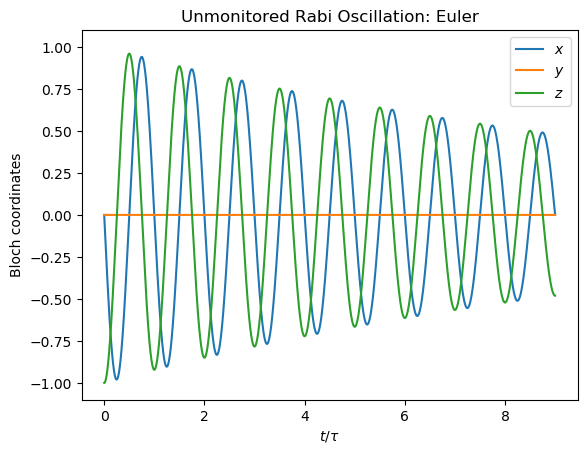

┌ Info: Timesteps: 
│   length(sol) = 90002
└ @ Main In[6]:4


In [8]:
@time sol = solve(probode, Euler(), dt=1/10^4);

plot_solution(sol, plot_title="Unmonitored Rabi Oscillation: Euler")

Compare this to a 4th-order Runge-Kutta method with $dt=10^{-2}$, for completeness.

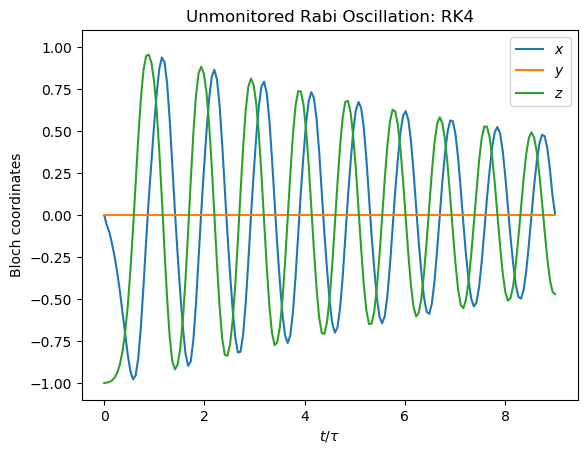

  1.867104 seconds (5.06 M allocations: 272.696 MiB, 1.42% gc time)


┌ Info: Timesteps: 
│   length(sol) = 173
└ @ Main In[6]:4


In [9]:
@time sol = solve(probode, RK4(), dt=1/10^2);

plot_solution(sol, plot_title="Unmonitored Rabi Oscillation: RK4")

### Euler-Marayama SME

Now, try the Euler-Marayama method, which is also an explicit first-order time-stepped method. Try both $dt=10^{-4}$ and $dt=10^{-5}$ to check convergence.  **Importantly: any excursions beyond the bounds of $\pm 1$ are unphysical, and indicative of a numerical precision failure.**

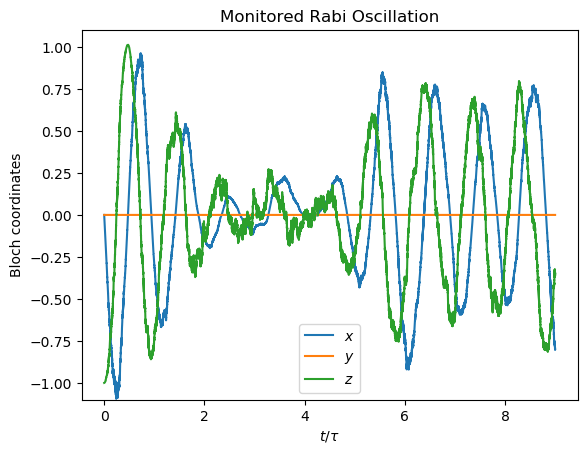

 13.839984 seconds (33.03 M allocations: 7.630 GiB, 13.30% gc time)


┌ Info: Timesteps: 
│   length(sol) = 90002
└ @ Main In[6]:4


In [10]:
@time sol = solve(probsde, EM(), dt=1/10^4);

plot_solution(sol)

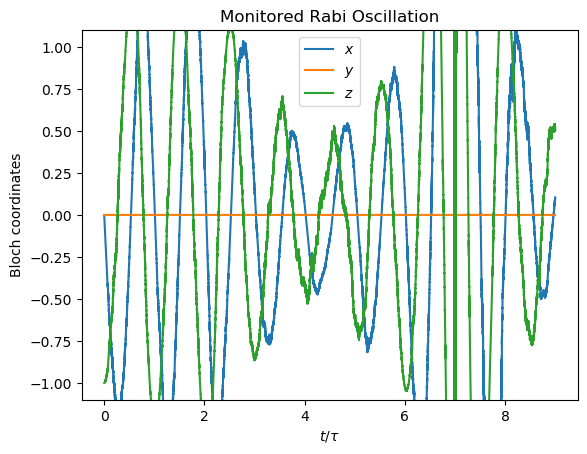

  6.112298 seconds (46.80 M allocations: 4.043 GiB, 31.74% gc time)


┌ Info: Timesteps: 
│   length(sol) = 900002
└ @ Main In[6]:4


In [11]:
@time sol = solve(probsde, EM(), dt=1/10^5);

plot_solution(sol)

Note that the first-order method yields unacceptable precision at $dt=10^{-4}$, which does not appreciably improve with an order of magnitude decrease in stepsize. This makes simulation of ensembles prohibitive.

### Rossler 1.5 SME

Next, try the explicitly order 1.5 Rossler method suitable for diagonal/scalar SDE, which should show improved precision over the order 1 EM method.

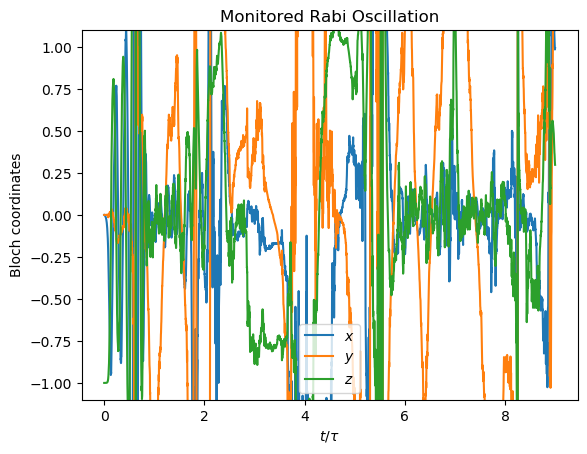

 12.676934 seconds (37.18 M allocations: 7.543 GiB, 10.09% gc time)


┌ Info: Timesteps: 
│   length(sol) = 4024
└ @ Main In[6]:4


In [15]:
@time sol = solve(probsde2, SRIW1(), dt=1/10^4);

plot_solution(sol)

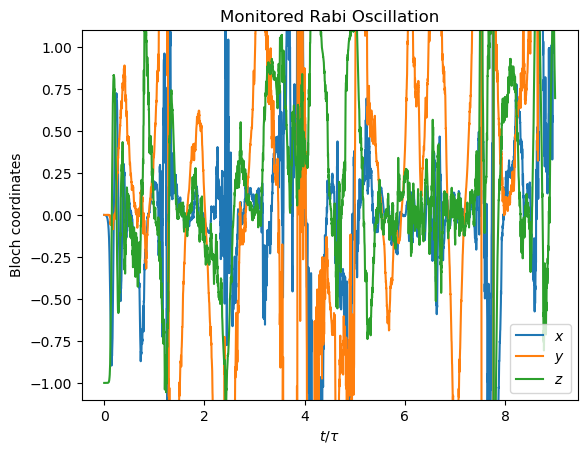

  0.059650 seconds (490.84 k allocations: 40.030 MiB)


┌ Info: Timesteps: 
│   length(sol) = 4485
└ @ Main In[6]:4


In [16]:
@time sol = solve(probsde2, SRIW1(), dt=1/10^5);

plot_solution(sol)

This also does not produce acceptable precision, despite the higher-order method.

### Runge-Kutta Milstein SME
Next, try the Order-1.0 RKMilstein method.

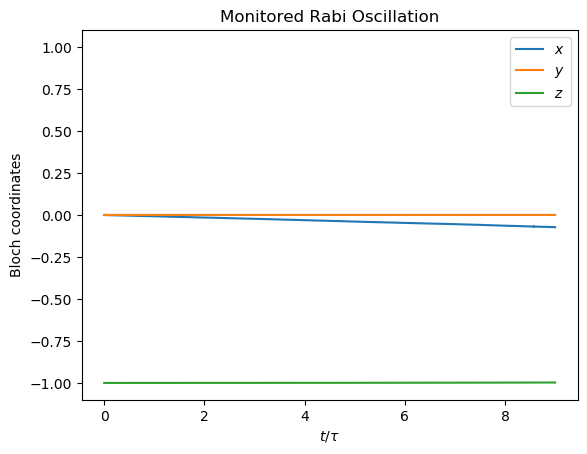

 38.443708 seconds (223.07 M allocations: 19.014 GiB, 13.38% gc time)


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /Users/luke/.julia/packages/DiffEqBase/xG5ve/src/integrator_interface.jl:329
┌ Info: Timesteps: 
│   length(sol) = 999914
└ @ Main In[6]:4


In [17]:
@time sol = solve(probsde, RKMil(), dt=1/10^4);

plot_solution(sol)

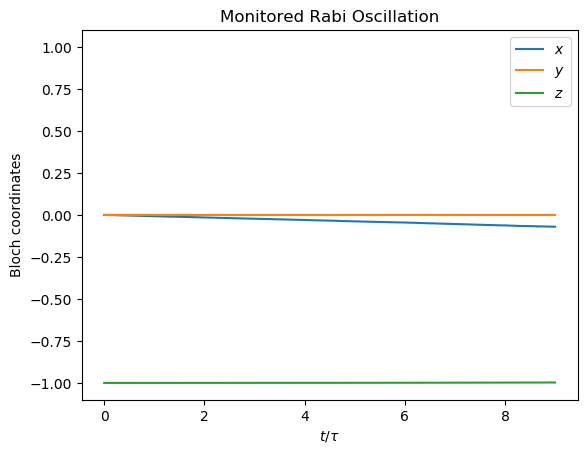

 28.522617 seconds (197.00 M allocations: 11.901 GiB, 16.26% gc time)


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /Users/luke/.julia/packages/DiffEqBase/xG5ve/src/integrator_interface.jl:329
┌ Info: Timesteps: 
│   length(sol) = 999943
└ @ Main In[85]:4


In [140]:
@time sol = solve(probsde, RKMil(), dt=1/10^5);

plot_solution(sol)

This performance is not notably better for $dt=10^{-5}$.

## Conclusions

None of the currently implemented stochastic integration methods are suitable for integrating even the simplest problem of monitored qubit dynamics.

## Version Information

In [18]:
versioninfo()

Julia Version 1.4.1
Commit 381693d3df* (2020-04-14 17:20 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7660U CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)
